<a href="https://colab.research.google.com/github/pvai-umich/SIADS697/blob/main/Data/Load_Kaggle_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

This notebook will contain the data loading scripts for the two kaggle data sets.

Set up the Kaggle login and API key:

In [1]:
import os
import zipfile
import pandas as pd

#comment

os.environ['KAGGLE_USERNAME'] = "pvaiciunas" # username from the json file
os.environ['KAGGLE_KEY'] = "fba13e65a047582a90e611238731617e" # key from the json file

## Kaggle Indeed Jobs Dataset

Source:
https://www.kaggle.com/promptcloud/indeed-job-posting-dataset

The next code block will download the zip file, unzip, and read the csv file into a pandas dataframe.

In [64]:
!kaggle datasets download -d promptcloud/indeed-job-posting-dataset # api copied from kaggle

with zipfile.ZipFile('indeed-job-posting-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

dat_indeed = pd.read_csv("home/sdf/marketing_sample_for_trulia_com-real_estate__20190901_20191031__30k_data.csv")


indeed-job-posting-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Kaggle Monster Jobs Dataset

Source:
https://www.kaggle.com/PromptCloudHQ/us-jobs-on-monstercom

The next code block will download the zip file, unzip, and read the csv file into a pandas dataframe.

In [ ]:
!kaggle datasets download -d PromptCloudHQ/us-jobs-on-monstercom

with zipfile.ZipFile('us-jobs-on-monstercom.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

dat_monster = pd.read_csv("monster_com-job_sample.csv")

 89% 17.0M/19.0M [00:00<00:00, 37.6MB/s]
100% 19.0M/19.0M [00:00<00:00, 35.2MB/s]


# Clean and Combine the Data


####Initial Thoughts

Ideally we'd like to combine the two data sets. Both have a job description that we can tokenize pretty easily. However, the challenge becomes in creating usable target variables. 

There is some sector information. So ideally we'd like the target variable to be a combination of the two. We could have two different models, one for sector, and one for job title, or make it one model for 'sector - job title'. However, the sector/industry data isn't present for Indeed like it is for Monster.

Getting both datasets on the same page though will be difficult.

#### Quick exploration code


In [ ]:
## Indeed Data
#dat_indeed.head()
#dat_indeed.columns
#dat_indeed['Job Description'][0] # Source for features
#dat_indeed['Job Title'].value_counts()[0:50] # source for target variable

## Monster Data
#dat_monster.head()
#dat_monster.columns
#dat_monster['job_description'][0] # Source for features
#dat_monster['job_title'].value_counts()[0:50] # Source for target variable
#dat_monster['sector'].value_counts() # Source for target variable
#dat_monster['organization'].value_counts() # Source for target variable



Create some graphs to show the prevalence of senior vs junior, as well as the concentrated nature of job types in the Indeed data

In [ ]:

import seaborn as sns

jobType_data = {'JobType' : ['Sales',
                             'Business Dev.',
                             'Retail',
                             'Finance',
                             'Graphic Design',
                             'Oil'],
                  'NumJobs' : [len(dat_indeed[dat_indeed['Job Title'].str.contains('Sales')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Business Development')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Retail')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Finan')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Graphic')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Oil')])]}
jobType_df = pd.DataFrame(data = jobType_data)

seniority_data = {'Title' : ['Senior / Executive',
                             'Manager / Director',
                             'Junior / Associate'],                             
                  'Count' : [len(dat_indeed[dat_indeed['Job Title'].str.contains('Senior|Executive')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Manager|Director')]),
                             len(dat_indeed[dat_indeed['Job Title'].str.contains('Junior|Associate|Trainee')])]}




seniority_df = pd.DataFrame(data = seniority_data)

Text(0.5, 1.0, 'Indeed Data Seniority')

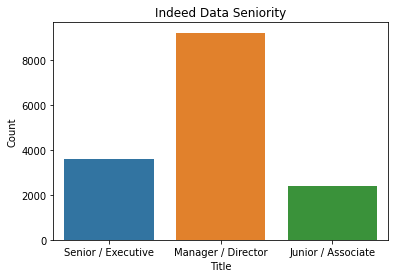

In [ ]:
sns.barplot(x="Title", y="Count", data=seniority_df).set_title('Indeed Data Seniority')

Text(0.5, 1.0, 'Indeed Data Job Type')

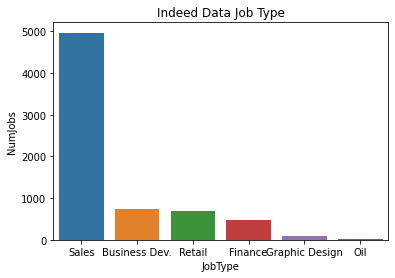

In [ ]:
sns.barplot(x="JobType", y="NumJobs", data=jobType_df).set_title('Indeed Data Job Type')

## Clean Indeed Data

'Job Description' holds the main text we'll need for creating features. We can use gensim to tokenize the job description as well as
add some common bigrams. Alternatively we can use TFID.

The bigger challenge will be getting the target variable in a 


#### Creating Target Variable

There are many similar titles but have an extra word or something that doesn't let it be combined with others. Will do some manual cleaning to get as much overlap between titles as possible. This is being done iteratively and manually.

In [65]:
# manually identify areas where we can clean titles to get things more homogenous
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Lids ','')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Senior ','')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Junior ','')

# Do some more specific cleaning of titles 
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace(', Retail Part Time','')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sales Associate/Beauty Advisor','Beauty Advisor')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('BEAUTY CONSULTANT','Beauty Advisor')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace(' I Store Operations','')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace(' - Prospecting - Financial Solutions','')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('General Manager II','General Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Entry Level Business Development Trainee – Traveling','Business Development')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('District Mgr in Training (DMIT)','District Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('HERO Assistant Store Manager Trainee (Military and Veterans)','Assistant Store Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Business Development Representative','Business Development')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Enterprise Sales Account Executive','Enterprise Account Executive')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('STORE MANAGER','Store Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace("Macy's Locker Room Assistant Manager Full-Time",'Assistant Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('General Manager Full Time-GMA-203100','General Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Business Development Associate','Business Development')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Merrill Lynch Financial Advisor Business Development Program','Financial Analyst')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Business Development Associate','Business Development')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Marketing Assistant','Marketing Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace("Macy's Locker Room Store Manager",'Store Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Assistant Manager Full-Time','Assistant Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sales Development Representative','Sales Representative')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Enterprise Sales Executive','Sales Executive')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Senior Account Executive','Account Executive')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sales Development Representative','Sales Representative')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Inside Sales Representative','Sales Representative')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sales Representative','Sales Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Restaurant Associate-Horizon','Restaurant Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Beauty Consultant','Beauty Advisor')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Associate Financial Advisor Development Program (AFADP)','Financial Advisor')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Senior Financial Analyst','Financial Analyst')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Store Manager in Training','Store Manager')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Regional Sales Director','Sales Director')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Seasonal Sales Associate','Sales Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Office Administrator','Administrator')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sales Associate (PT)','Sales Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('PT Perishable Associate','Perishable Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('FT Perishable Associate','Perishable Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Business Development Manager','Business Development')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Salesperson','Sales Associate')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sales Director','Sales Executive')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Purchasing Agent','Buyer')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Director of Sales','Sales Director')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Business Analyst','Financial Analyst')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Staff Accountant','Accountant')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Accounting Manager','Accountant')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sr. Financial Analyst','Financial Analyst')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Finance Manager','Financial Analyst')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Associate Financial Advisor Development Program (AFADP)','Financial Analyst')



# Want to add some more of these titles if possible
#dat_indeed2['Job Title'] = dat_indeed2['Job Title'].str.replace('','Software Engineer')
#dat_indeed2['Job Title'] = dat_indeed2['Job Title'].str.replace('','Financial Analyst')
#dat_indeed2['Job Title'] = dat_indeed2['Job Title'].str.replace('','Staff Accountant')
#dat_indeed2['Job Title'] = dat_indeed2['Job Title'].str.replace('','Marketing Associate')
#dat_indeed2['Job Title'] = dat_indeed2['Job Title'].str.replace('','Graphic Designer')


# And a whole section on data-related ones so that we can include 'data scientist' in the results
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Finance Data Analyst','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Marketing Data Analyst','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Business Data Analyst','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Cloud Data Architect','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Azure Data Architect ','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Lead Data Scientist','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Head of Data','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('AWS Data Architect','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Data Engineer II','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('SAP Data Architect (MDG, BODS) - Manager','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Data Entry Clerk','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sr Data Architect - Data Warehouse & MPP - Nationwide Opportunities','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('SAP Data Architect (MDG, BODS) - Specialist Leader','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Sr Data Architect - Data Lake & Analytics - Nationwide Opportunities','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Data Strategy Architect - Cloud, Big Data, Analytics, ML/AI/Data Science','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Quant Specialist Sales (Enterprise Data Sales)','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('SAP Data Scientist (MDG, BODS) - Consultant','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Big Data Scientist','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Data Analyst','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Data Architect','Data Scientist')
dat_indeed['Job Title'] = dat_indeed['Job Title'].str.replace('Data Engineer','Data Scientist')




In [66]:
def clean_tokenize_text(df, column):
    """
    input: {pandas DataFrame, string object} dataframe with text to be tokenized in column name provided
    return: {pandas DataFrame} dataframe with appended 'tokens' and 'stem_tokens' columns
    
    """
    CUSTOM_STOP_WORDS = ['â¢', 'â', 'â', 'â¢', 'â','®', '�',
                         '\\u200','comment','connect','message','\\xa0',
                         'share','mo','month','follow','report',
                         'block','profile','yr','year','date',
                         'contact','jan','january','feb','february',
                         'mar','march','apr','april','may','jun',
                         'june','jul','july','aug','august','sep',
                         'sept','september','oct','october','nov',
                         'november','dec','december','yddscsgylniquit',
                         'srmysiridmcwdydzygf'
                        ]
    CUSTOM_STEM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_numeric, stem_text]
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_numeric]
    tokens = []
    s_tokens = []
    stem_tokens = []
    s_stem_tokens = []
    for s in df[column]:
        tokens = preprocess_string(s, CUSTOM_FILTERS)
        tokens = [x for x in tokens if len(x) > 1]
        
        stem_tokens = preprocess_string(s, CUSTOM_STEM_FILTERS)
        stem_tokens = [x for x in stem_tokens if len(x) > 1]
        
        s_stem_tokens.append(stem_tokens)
        s_tokens.append(tokens)
    df['tokens'] = s_tokens
    df['stem_tokens'] = s_stem_tokens
    return df

#### Creating Features

We will first create features for the actual model which will utilize gensim and keep each job line item separate.

We will then also use a faster tokenizing script to re-tokenize the dataframe but also combine all these simpler tokens for each unique job title we'll be using in the final model. This is so that we can have a smaller data file that we can load directly into the web app and reference for the skills gap part of the application.

In [67]:
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS

# Only keep the job titles with more than 75 records.
job_titles_to_keep = dat_indeed['Job Title'].value_counts()
job_titles_to_keep = job_titles_to_keep[job_titles_to_keep > 75].index.tolist()
dat_indeed = dat_indeed[dat_indeed['Job Title'].isin(job_titles_to_keep)]

# Default tokenization of the job description
dat_indeed['tokens'] = dat_indeed['Job Description'].apply(lambda x: preprocess_string(x))

# Remove the stopwords
dat_indeed['tokens'] = dat_indeed['tokens'].apply(lambda x: [words for words in x if not words in STOPWORDS])

# Put back into a single string for use in TFIDVectorizer later
dat_indeed['tokens'] = dat_indeed['tokens'].apply(' '.join)
  

In [68]:
# Create a mini dataset from the tokens that we can upload as a txt file and use to 
# quickly determine the skill gap in the web app. Will combine all the tokens
# found for each unique job.
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import preprocess_string,strip_punctuation, strip_multiple_whitespaces, remove_stopwords, stem_text, STOPWORDS, strip_numeric, strip_tags

dat_indeed2 = dat_indeed.copy()
dat_indeed2 = dat_indeed2.drop(columns=['tokens'])
dat_indeed2 = clean_tokenize_text(dat_indeed2, "Job Description")


In [70]:
# Create a dictionary so that we only have unique job titles
mini_dat = {}
for i in range(dat_indeed2.shape[0]):
  temp_job = dat_indeed2['Job Title'].iloc[i]
  temp_tokens = dat_indeed2['stem_tokens'].iloc[i]
  if temp_job in mini_dat.keys():
    mini_dat[temp_job].extend(temp_tokens)
  else:
    mini_dat[temp_job] = temp_tokens
  
# Then convert to a dataframe that we can export as a txt file
mini_dat = pd.DataFrame(data = {'Job Title':mini_dat.keys(),
                                'Job Tokens':mini_dat.values()})

#mini_dat.to_csv(r'mini_dat.txt', header=None, index=None, sep=' ', mode='a')

In [21]:
mini_dat = pd.DataFrame()


(4515, 31)

##Build a Model

Will use a simple Logistic Regression to start, then move on from there.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


# Split the data to train and test.
split_df = np.split(dat_indeed.sample(frac = 1, random_state = 42), [int(len(dat_indeed)*0.8), int(len(dat_indeed)*0.9), int(len(dat_indeed)*0.9)])
train_df = split_df[0]
val_df = split_df[1]
test_df = split_df[2]

# Vectorize the tokens. Will use a minimum of 200 for usage.
vectorizer = TfidfVectorizer(min_df = 100, stop_words = 'english', ngram_range =(1,2))
X_train = vectorizer.fit_transform(train_df['tokens'])
y_train = list(train_df['Job Title'])

X_val = vectorizer.transform(val_df['tokens'])
y_val = list(val_df['Job Title'])


# Fit a simple Logistic Regression Model
clf = LogisticRegression(random_state = 42, solver = 'lbfgs', multi_class = 'auto')
clf.fit(X_train, y_train)

# Some dummy classifiers to test performance
dummy_clf_unif = DummyClassifier(random_state = 42, strategy = "uniform")
dummy_clf_mostf = DummyClassifier(random_state = 42, strategy = "most_frequent")

dummy_clf_unif.fit(X_train, y_train)
dummy_clf_mostf.fit(X_train, y_train)


# Create predictions
preds_lr = clf.predict(X_val)
pred_dummy_unif = dummy_clf_unif.predict(X_val)
pred_dummy_mostf = dummy_clf_mostf.predict(X_val)


# Scoring

acc_lr = accuracy_score(y_val, preds_lr, normalize = True)
acc_unif = accuracy_score(y_val, pred_dummy_unif, normalize = True)
acc_mostf = accuracy_score(y_val, pred_dummy_mostf, normalize = True)

f1_lr = f1_score(y_val, preds_lr, average='macro')
f1_unif = f1_score(y_val, pred_dummy_unif, average='macro')
f1_mf = f1_score(y_val, pred_dummy_mostf, average='macro')



In [ ]:
f1_lr, f1_unif, f1_mf

(0.8674897379675345, 0.020911567874630256, 0.010757946210268949)

In [ ]:
acc_lr, acc_unif, acc_mostf

(0.8684931506849315, 0.024657534246575342, 0.12054794520547946)

In [ ]:
input = "This is an example of an input. I really like taxes in high school, and beauty accountant with beauty and other things like that. I loved to go out and socialize as well."
clean_input = " ".join(preprocess_string(input))

clf.predict(vectorizer.transform([clean_input]))


array(['Beauty Advisor'], dtype='<U31')